# GUI based Inventory Optimization

In [4]:
import tkinter as tk
from tkinter import ttk, messagebox
import pandas as pd
import numpy as np

# Initialize df as None
df = None

# Load CSV Data
def load_data():
    global df
    file_path = "DMart_Grocery_Sales.csv"  # Updated CSV file path
    df = pd.read_csv(file_path)

    # Display basic data information
    total_rows = df.shape[0]
    total_columns = df.shape[1]
    welcome_label.config(text=f"Welcome to DMart Inventory Management!\nTotal Records: {total_rows}\nTotal Columns: {total_columns}")

    # Clear existing columns
    tree["columns"] = list(df.columns)
    tree["show"] = "headings"

    # Create new column headers dynamically with sorting feature
    for col in df.columns:
        tree.heading(col, text=col, command=lambda c=col: sort_by_column(c, False))
        tree.column(col, width=150, anchor="center")

    # Populate Sub Category dropdown
    subcategories = sorted(df['Sub Category'].dropna().unique().tolist())
    subcategory_combobox['values'] = subcategories
    
    update_treeview(df)

# Function to sort columns
def sort_by_column(col, reverse):
    global df
    df = df.sort_values(by=col, ascending=not reverse)
    update_treeview(df)
    tree.heading(col, command=lambda: sort_by_column(col, not reverse))

# Update Treeview with Data
def update_treeview(data):
    tree.delete(*tree.get_children())  # Clear existing data
    for _, row in data.iterrows():
        tree.insert("", "end", values=list(row))

# Search Function (Restricted to "Sub Category" column)
def search():
    query = subcategory_combobox.get()
    
    if "Sub Category" not in df.columns:
        messagebox.showerror("Error", "The column 'Sub Category' is missing in the dataset.")
        return
    
    filtered_data = df[df['Sub Category'].astype(str) == query]
    
    if filtered_data.empty:
        messagebox.showerror("No Results", "No matching subcategory found!")
    else:
        update_treeview(filtered_data)

# Provide Suggestions Based on Inventory Analysis
def get_suggestions(eoq, rop, total_cost):
    suggestions = []

    if eoq < 50:
        suggestions.append("Consider increasing order quantity to reduce frequent ordering costs.")
    elif eoq > 500:
        suggestions.append("You may be overstocking. Reduce order size to lower holding costs.")

    if rop < 30:
        suggestions.append("Your reorder point is low. Consider increasing safety stock to avoid stockouts.")
    elif rop > 200:
        suggestions.append("Your reorder point is quite high. Review lead times to optimize stock levels.")

    if total_cost > 300000:
        suggestions.append("Total cost is quite high. Consider negotiating with suppliers for bulk discounts.")

    if not suggestions:
        suggestions.append("Inventory is well-optimized. Keep monitoring demand trends.")

    return "\n".join(suggestions)

# Calculate EOQ, ROP, and Total Cost, Show Results, and Give Suggestions
def calculate_inventory():
    try:
        daily_demand = float(daily_demand_entry.get())
        ordering_cost = float(ordering_cost_entry.get())
        holding_cost = float(holding_cost_entry.get())
        lead_time = float(lead_time_entry.get())
        safety_stock = float(safety_stock_entry.get())
        unit_cost = float(unit_cost_entry.get())

        annual_demand = daily_demand * 365
        eoq = round(np.sqrt((2 * annual_demand * ordering_cost) / holding_cost), 2)
        rop = round((daily_demand * lead_time) + safety_stock, 2)
        total_cost = round((eoq / 2 * holding_cost) + (annual_demand / eoq * ordering_cost) + (annual_demand * unit_cost), 2)

        suggestions = get_suggestions(eoq, rop, total_cost)

        messagebox.showinfo(
            "Inventory Optimization Results",
            f"EOQ: {eoq}\nROP: {rop}\nTotal Cost: {total_cost}\n\nSuggestions:\n{suggestions}"
        )

    except ValueError:
        messagebox.showerror("Input Error", "Please enter valid numeric values.")

# GUI Window
root = tk.Tk()
root.title("DMart Inventory Management")
root.geometry("1200x600")  # Increased size to fit more columns

# Welcome Message
welcome_label = tk.Label(root, text="Welcome to DMart Inventory Management!", font=("Arial", 14, "bold"))
welcome_label.pack(pady=10)

# Search Bar with Dropdown
subcategory_combobox = ttk.Combobox(root, width=47, state="readonly")
subcategory_combobox.pack(pady=10)
search_button = tk.Button(root, text="Search Sub Category", command=search)
search_button.pack()

# Treeview Table
tree = ttk.Treeview(root)
tree.pack(expand=True, fill="both")

# Inventory Calculation Inputs
frame = tk.Frame(root)
frame.pack(pady=10)

tk.Label(frame, text="Daily Demand:").grid(row=0, column=0)
daily_demand_entry = tk.Entry(frame)
daily_demand_entry.grid(row=0, column=1)

tk.Label(frame, text="Ordering Cost:").grid(row=1, column=0)
ordering_cost_entry = tk.Entry(frame)
ordering_cost_entry.grid(row=1, column=1)

tk.Label(frame, text="Holding Cost:").grid(row=2, column=0)
holding_cost_entry = tk.Entry(frame)
holding_cost_entry.grid(row=2, column=1)

tk.Label(frame, text="Lead Time (days):").grid(row=3, column=0)
lead_time_entry = tk.Entry(frame)
lead_time_entry.grid(row=3, column=1)

tk.Label(frame, text="Safety Stock:").grid(row=4, column=0)
safety_stock_entry = tk.Entry(frame)
safety_stock_entry.grid(row=4, column=1)

tk.Label(frame, text="Unit Cost:").grid(row=5, column=0)
unit_cost_entry = tk.Entry(frame)
unit_cost_entry.grid(row=5, column=1)

calculate_button = tk.Button(root, text="Calculate EOQ, ROP, Total Cost", command=calculate_inventory)
calculate_button.pack(pady=10)

# Load Data After Treeview is Created
load_data()

# Run Application
root.mainloop()


# Sales Forecasting for the next 30 days

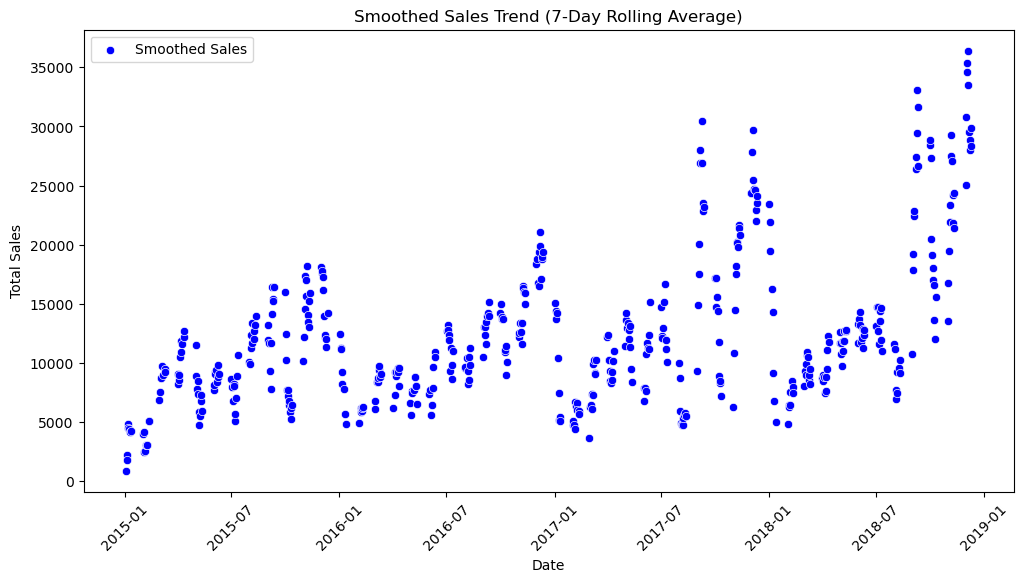

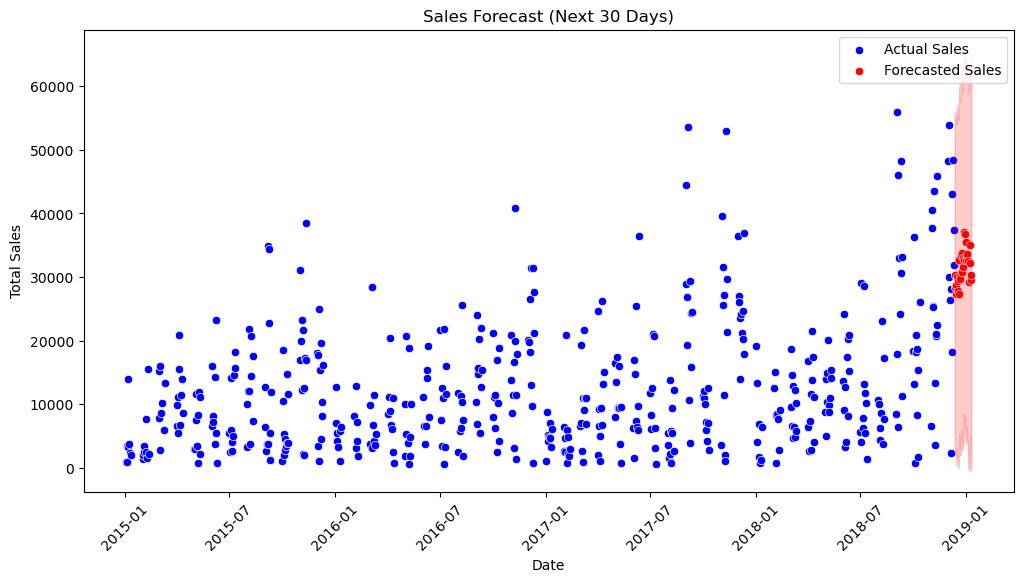

Predicted Sales for Next 10 Days:
2018-12-12: 30284.16
2018-12-13: 28429.46
2018-12-14: 28817.88
2018-12-15: 27273.32
2018-12-16: 30049.77
2018-12-17: 27733.57
2018-12-18: 29457.1
2018-12-19: 27390.35
2018-12-20: 32732.73
2018-12-21: 30223.03
📈 Sales are increasing! Consider stocking up on popular products and optimizing inventory levels.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")

# Load dataset
file_path = "DMart_Grocery_Sales.csv"  # Update with correct file path
df = pd.read_csv(file_path)

# Convert 'Order Date' to datetime and sort
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df.dropna(subset=['Order Date'])
df = df.sort_values(by="Order Date")

# Aggregate sales per day
sales_trend = df.groupby('Order Date')['Sales'].sum().reset_index()
sales_trend.set_index('Order Date', inplace=True)

# Apply rolling average to smooth fluctuations
sales_trend['Sales_Smoothed'] = sales_trend['Sales'].rolling(window=7, min_periods=1).mean()

# Plot smoothed sales trend
plt.figure(figsize=(12, 6))
sns.scatterplot(x=sales_trend.index, y=sales_trend['Sales_Smoothed'], label="Smoothed Sales", color='blue')
plt.title("Smoothed Sales Trend (7-Day Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Train SARIMA Model
sarima_model = SARIMAX(sales_trend['Sales'], 
                        order=(1, 1, 1),  
                        seasonal_order=(1, 1, 1, 30),  
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Forecast for the next 30 days
forecast_steps = 30
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=sales_trend.index[-1], periods=forecast_steps + 1, freq='D')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot forecasted sales
plt.figure(figsize=(12, 6))
sns.scatterplot(x=sales_trend.index, y=sales_trend['Sales'], label="Actual Sales", color="blue")
sns.scatterplot(x=forecast_index, y=forecast_values, label="Forecasted Sales", color="red")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)
plt.title("Sales Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Print predictions and suggestions
print("Predicted Sales for Next 10 Days:")
predicted_sales_list = list(zip(forecast_index[:10], forecast_values[:10]))
for date, value in predicted_sales_list:
    print(f"{date.date()}: {round(value, 2)}")

# Provide suggestions based on trends
if forecast_values.mean() > sales_trend['Sales'].mean():
    print("Sales are increasing! Consider stocking up on popular products and optimizing inventory levels.")
elif forecast_values.mean() < sales_trend['Sales'].mean():
    print("Sales are declining. You may need to offer promotions or optimize pricing strategies.")
else:
    print("Sales are stable. Maintain current strategies while monitoring for any sudden changes.")
